In [36]:
import sys
import os 
import shap
import numpy as np
import pandas as pd
from src import data_loading, preprocessing, training, eval, utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath('..'))

# Load previously cleand data
df = data_loading.load_data('../data/processed/credit_default_engineered.csv')

# Load X & y and encoded features 
X, y = preprocessing.encode_features(df, 'default')

print (X.shape, y.shape)

(30000, 30) (30000,)


# Feature pre processing

In [37]:
# feature scaling 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled array back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.1, random_state=42)

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27000, 30) (3000, 30) (27000,) (3000,)


## Baseline Model

In [38]:
# Logistic Regression
lr = training.train_LR(X_train, y_train)

In [39]:
# Random Forest
rf = training.train_RF(X_train, y_train)

In [40]:
# XGBoost 
xg = training.train_XGB(X_train, y_train)

# Model Evaluation

In [41]:
# Evaluating models
print('LR Metrics:', eval.evaluate_model(lr, X_test, y_test))
print('RF Metrics:', eval.evaluate_model(rf, X_test, y_test))
print('XGB Metrics:', eval.evaluate_model(xg, X_test, y_test))

LR Metrics: {'AUC': 0.7595868074484077, 'Recall': 0.2852807283763278, 'Precision': 0.6372881355932203, 'F1': 0.3941299790356394, 'Accuracy': 0.8073333333333333, 'Confusion Matrix': array([[2234,  107],
       [ 471,  188]], dtype=int64)}
RF Metrics: {'AUC': 0.7860238967692755, 'Recall': 0.5766312594840668, 'Precision': 0.5053191489361702, 'F1': 0.5386250885896527, 'Accuracy': 0.783, 'Confusion Matrix': array([[1969,  372],
       [ 279,  380]], dtype=int64)}
XGB Metrics: {'AUC': 0.7889249435574464, 'Recall': 0.37784522003034904, 'Precision': 0.6784741144414169, 'F1': 0.4853801169590643, 'Accuracy': 0.824, 'Confusion Matrix': array([[2223,  118],
       [ 410,  249]], dtype=int64)}


## Model Selection & Development

In [42]:
# threshold tuning for XGBoost & RF
print("RF:", eval.find_best_threshold(rf, X_test, y_test))
print("XGB:", eval.find_best_threshold(xg, X_test, y_test))

RF: {'best_threshold': 0.5691381205612046, 'best_f1': 0.5505882347946862, 'precision': 0.5698051948051948, 'recall': 0.5326251896813353}
XGB: {'best_threshold': 0.32640398, 'best_f1': 0.5603644641924832, 'precision': 0.560790273556231, 'recall': 0.5599393019726859}


In [43]:
# Re-evaluate RF and XGBoost with new thresholds

print("RF tuned:", eval.evaluate_with_threshold(rf, X_test, y_test, 0.5573431706564606))
print("XGB tuned:", eval.evaluate_with_threshold(xg, X_test, y_test, 0.3210463))

RF tuned: {'Recall': 0.5417298937784522, 'Precision': 0.5543478260869565, 'F1': 0.5479662317728319, 'Accuracy': 0.8036666666666666, 'Confusion Matrix': array([[2054,  287],
       [ 302,  357]], dtype=int64)}
XGB tuned: {'Recall': 0.5599393019726859, 'Precision': 0.5540540540540541, 'F1': 0.5569811320754717, 'Accuracy': 0.8043333333333333, 'Confusion Matrix': array([[2044,  297],
       [ 290,  369]], dtype=int64)}


In [44]:
# Optimizing Recall @ fixed precision

print('RF:', eval.optimize_recall(rf, X_test, y_test, 0.6))
print('XGB:', eval.optimize_recall(xg, X_test, y_test, 0.6))

RF: {'best_recall': 0.47192716236722304, 'best_threshold': 0.6402878143910292}
XGB: {'best_recall': 0.5053110773899848, 'best_threshold': 0.37051135}


## Model Insight

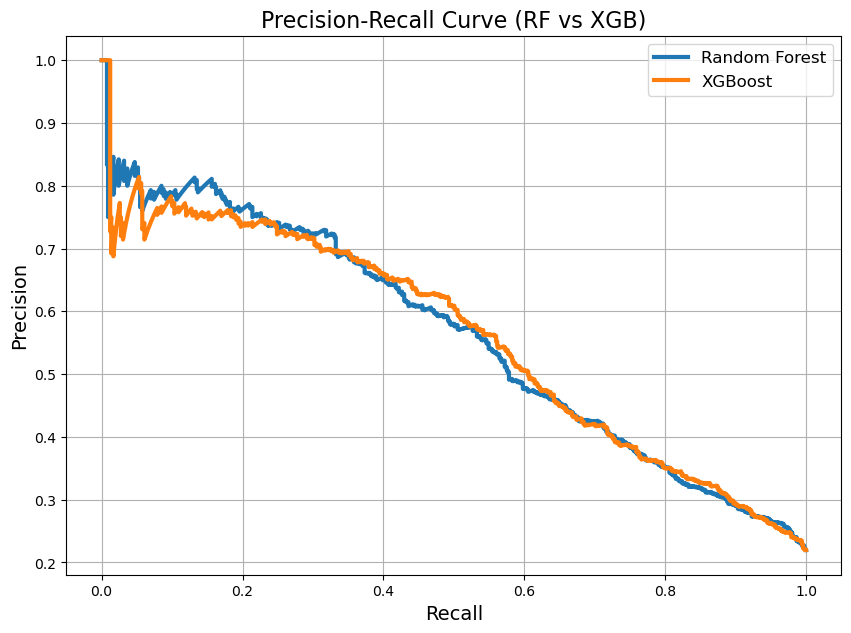

In [45]:
# compute and plot precision-recall curve for rf and xgb models
utils.plot_prec_reca(rf, xg, X_test, y_test)

### Model explainability for XGB (Selected Model)

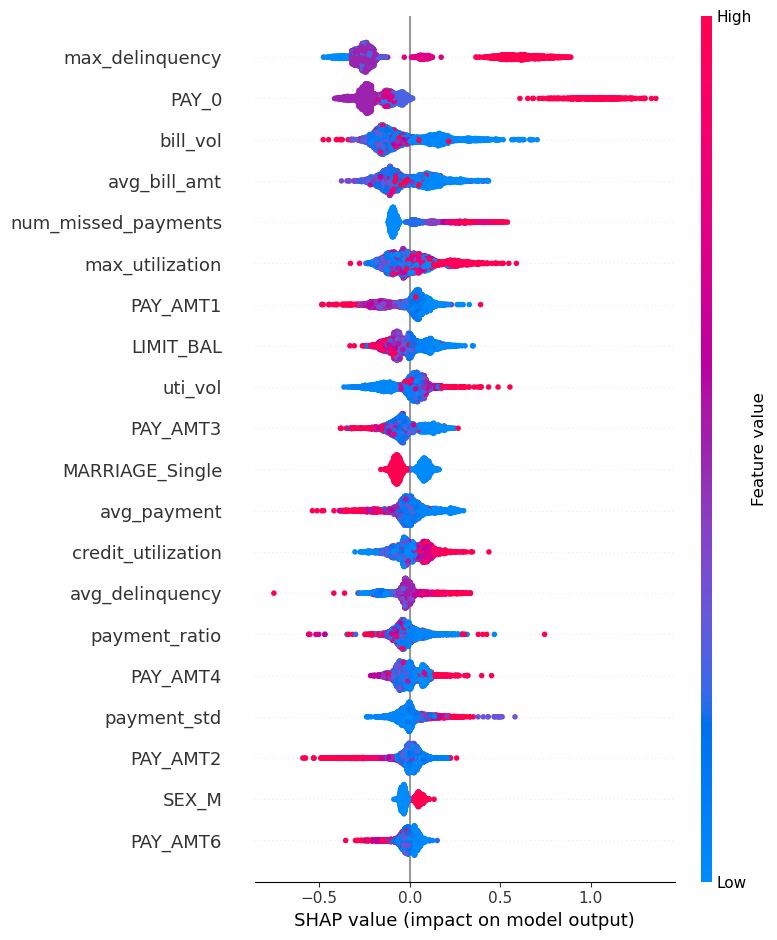

In [46]:
# SHAP summary plot
explainer = shap.TreeExplainer(xg)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

## Post-model governance 
### Model Risk accessment <br>
| Stability Ratio | Interpretation | 
| --------------- | -------------- | 
| **< 0.6**       | Stable         |
| **0.6 – 0.85**  | Medium         | 
| **> 0.85**      | Unstable       | 


In [47]:
# SHAP Stability check
stability = eval.shap_stab_check(xg, X_test)
stability.head(10)


,feature,mean_abs_shap,std_abs_shap,stability_ratio
11,max_delinquency,0.348246,0.182440,0.523882
1,PAY_0,0.262323,0.265957,1.013856
19,bill_vol,0.147356,0.089085,0.604553
16,avg_bill_amt,0.118775,0.068563,0.577254
13,num_missed_payments,0.112735,0.088785,0.787560
18,max_utilization,0.098208,0.081181,0.826616
5,PAY_AMT1,0.087463,0.071357,0.815852
0,LIMIT_BAL,0.082236,0.056026,0.681287
20,uti_vol,0.080428,0.068564,0.852483
7,PAY_AMT3,0.079319,0.054782,0.690650


## Saving trained models

In [49]:
import joblib

joblib.dump(xg, 'XGB.pk1')
joblib.dump(rf, 'RF.pk1')
joblib.dump(lr, 'LR.pk1')
joblib.dump(scaler, 'scaler.pk1')

['scaler.pk1']